In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import joblib

In [12]:
df = pd.read_csv('Historical Product Demand.csv')
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [13]:
df.sort_values(by='Date', ignore_index=True, inplace=True)
df.head()
df


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011/1/8,2
1,Product_0412,Whse_S,Category_007,2011/10/20,(2)
2,Product_0125,Whse_S,Category_011,2011/10/20,(2)
3,Product_0642,Whse_C,Category_019,2011/10/31,3
4,Product_2137,Whse_S,Category_009,2011/11/18,(25)
...,...,...,...,...,...
1048570,Product_1464,Whse_A,Category_019,NaN,(900)
1048571,Product_1541,Whse_A,Category_019,NaN,(200)
1048572,Product_1388,Whse_A,Category_019,NaN,(300)
1048573,Product_1541,Whse_A,Category_019,NaN,(300)


In [14]:
df.dropna()
df['Order_Demand'] = df['Order_Demand'].str.replace('(',"")
df['Order_Demand'] = df['Order_Demand'].str.replace(')',"")

# change the dtype as int64
df['Order_Demand'] = df['Order_Demand'].astype('int64')
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011/1/8,2
1,Product_0412,Whse_S,Category_007,2011/10/20,2
2,Product_0125,Whse_S,Category_011,2011/10/20,2
3,Product_0642,Whse_C,Category_019,2011/10/31,3
4,Product_2137,Whse_S,Category_009,2011/11/18,25
...,...,...,...,...,...
1048570,Product_1464,Whse_A,Category_019,NaN,900
1048571,Product_1541,Whse_A,Category_019,NaN,200
1048572,Product_1388,Whse_A,Category_019,NaN,300
1048573,Product_1541,Whse_A,Category_019,NaN,300


In [15]:
df['Month'] = pd.to_datetime(df['Date']).dt.month
le = LabelEncoder()
df['Product_Encoded'] = le.fit_transform(df['Product_Code'])

In [16]:
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')  # Convert to numeric, handle errors by converting to NaN


In [17]:
for i in range(1, 13):
    df[f'Orders_Lag_{i}'] = df['Order_Demand'].shift(i)
df = df.dropna()

In [18]:
X = df[['Product_Encoded', 'Month'] + [f'Orders_Lag_{i}' for i in range(1, 13)]]
y = df['Order_Demand']


In [19]:
# df[:1000].to_csv("newdata.csv", index=False)

In [20]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_lstm = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y.values, test_size=0.2, random_state=42)

In [21]:
model = keras.Sequential([
    layers.LSTM(64,  return_sequences=True, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])),
    layers.LSTM(64, activation='relu'),
    layers.Dense(1)  # Output layer for regression
])

2024-01-21 07:23:49.136120: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 07:23:49.137236: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [20]:
model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)


Epoch 1/3

20747/20747 [==============================] - 64s 3ms/step - loss: 883663552.0000 - val_loss: 791946880.0000
Epoch 2/3
20747/20747 [==============================] - 61s 3ms/step - loss: 881712576.0000 - val_loss: 789517632.0000
Epoch 3/3
20747/20747 [==============================] - 68s 3ms/step - loss: 874944256.0000 - val_loss: 779371712.0000


In [21]:
y_pred_lstm = model.predict(X_test)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
print(f'LSTM Root Mean Squared Error: {rmse_lstm}')


6484/6484 [==============================] - 11s 2ms/step
LSTM Root Mean Squared Error: 27399.073088126905


In [22]:
X_pred_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
monthly_predictions_lstm = model.predict(X_lstm)

32417/32417 [==============================] - 54s 2ms/step


In [24]:
df['Predicted_Sales_LSTM'] = monthly_predictions_lstm.flatten()
top_sellers_lstm = df.groupby(['Month', 'Product_Code']).agg({'Predicted_Sales_LSTM': 'mean'}).sort_values(by='Predicted_Sales_LSTM', ascending=False).groupby('Month').head(2)



C:\Users\karan\AppData\Local\Temp\ipykernel_8548\1431622465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Predicted_Sales_LSTM'] = monthly_predictions_lstm.flatten()


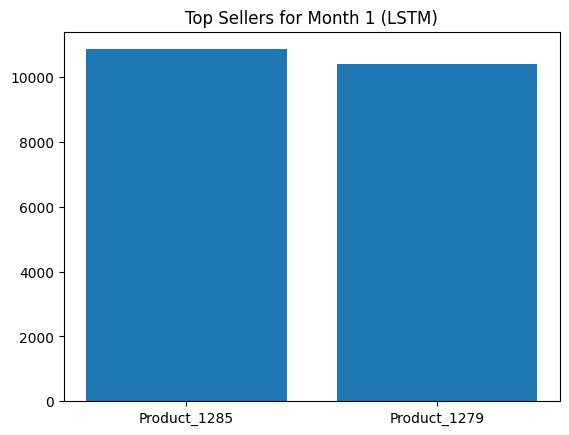

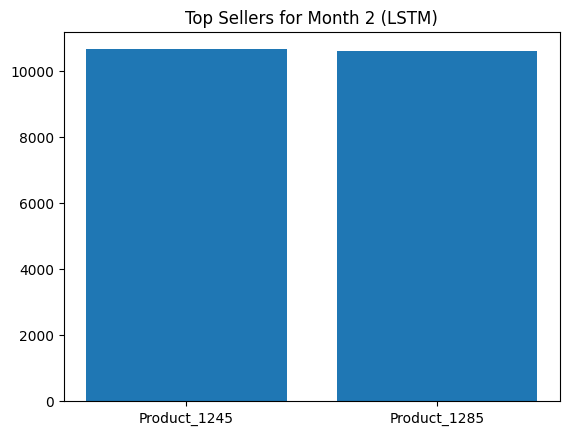

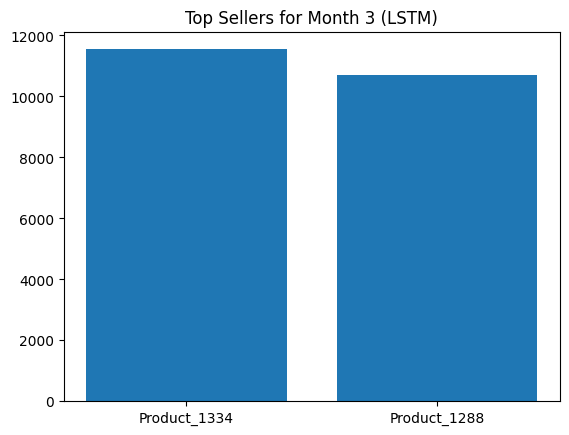

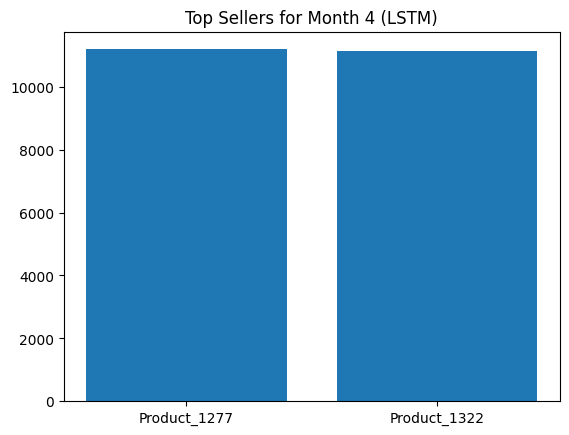

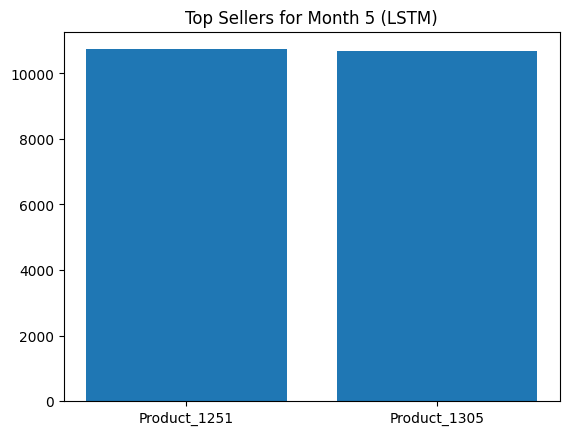

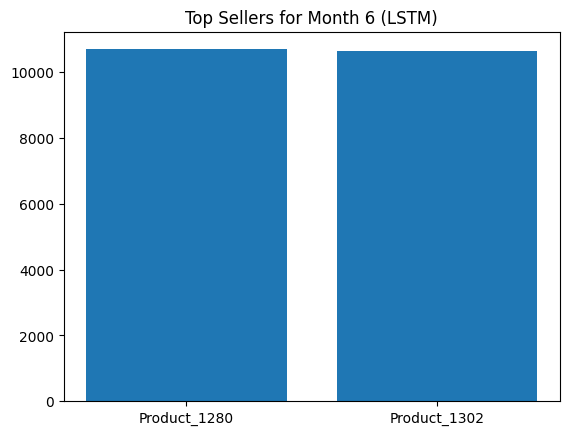

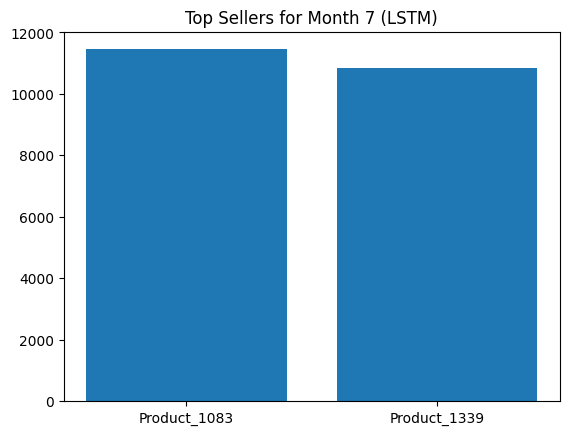

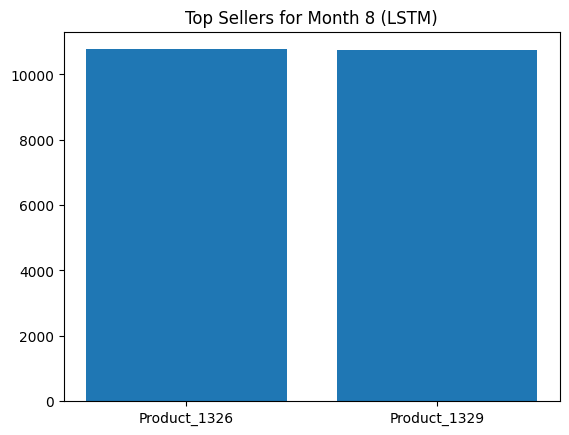

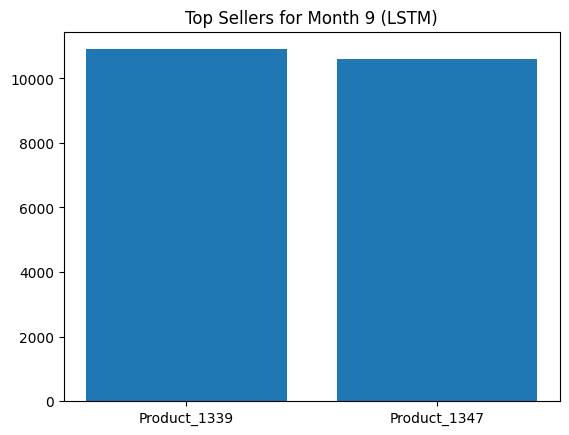

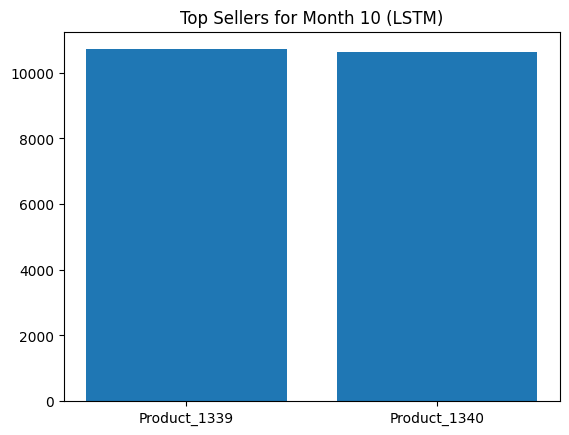

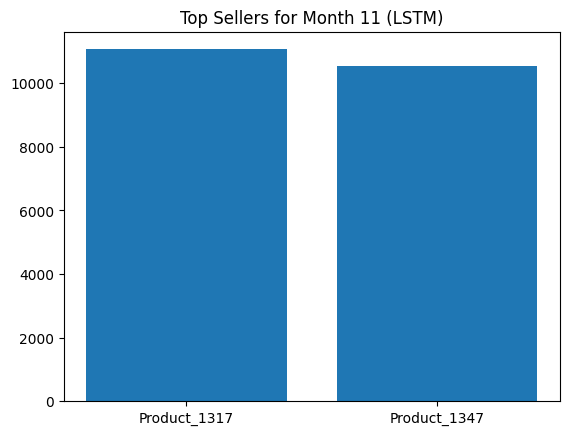

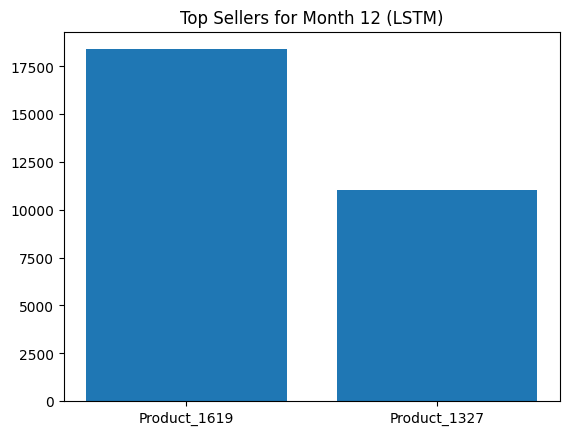

In [26]:
for month in range(1, 13):
    monthly_data_lstm = top_sellers_lstm[top_sellers_lstm.index.get_level_values('Month') == month]
    plt.bar(monthly_data_lstm.index.get_level_values('Product_Code'), monthly_data_lstm['Predicted_Sales_LSTM'])
    plt.title(f'Top Sellers for Month {month} (LSTM)')
    plt.show()

In [29]:
joblib.dump(model, 'Monthly.joblib')

['Monthly.joblib']